In [1]:
import numpy as np
import pandas as pd
import spacy
import nltk
from nltk.stem import WordNetLemmatizer
import os
import string
import matplotlib.pyplot as plt
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import words
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import gensim.downloader as api
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('words')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

In [2]:
# will be used to analyse all three dataframes 
word_vectors = api.load('glove-wiki-gigaword-300')

[==================================================] 100.0% 376.1/376.1MB downloaded


In [3]:
blogdf = pd.read_csv('/content/drive/MyDrive/text_mining_project/naturalscience/attempt2.csv')

# to carve out a data frame which contains only blog posts pertaining discusions about biology
biology_df = blogdf[blogdf['Topic'] == 'Biology'].dropna(how="any")
biology_df 

,Unnamed: 0,Id,Comment,Topic,cleaned_Comments
0,0,0x840,A few things. You might have negative- frequen...,Biology,thing you might negative frequency dependent s...
2,2,0x1dfc,There are bees,Biology,there bee
3,3,0xc7e,I'm a medication technician. And that's alot o...,Biology,medication technician and alot drug liver you ...
6,6,0x1f3d,Shove it up your ass and see what happens,Biology,shove see happens
8,8,0xe05,https://t.me/joinchat/3gElLHLuMCxhNGI0,Biology,http
...,...,...,...,...,...
10269,1574,0x1a05,"They are all over here in Louisiana, we call t...",Biology,they louisiana call stink bug put horrible sme...
10271,1576,0x234a,The error rate depends on the technology used....,Biology,the error rate depends technology used typical...
10272,1577,0x2523,You could also put it in terms of light wave l...,Biology,you could also put term light wave length size...
10277,1582,0x1f4a,i really empathize with your compassion for bu...,Biology,really empathize compassion bug entomology rea...


In [4]:
# to carve out a data frame which contains only blog posts pertaining discusions about physics
physics_df = blogdf[blogdf['Topic'] == 'Physics'].dropna(how="any")
physics_df 

,Unnamed: 0,Id,Comment,Topic,cleaned_Comments
1,1,0xbf0,Is it so hard to believe that there exist part...,Physics,hard believe exist particular detect anything ...
18,18,0x31c,There's also a glorious spy device which uses ...,Physics,there also glorious spy device laser rangefind...
20,20,0x10aa,"Funny video, but I hate ad reads mid-video. I'...",Physics,funny video hate read rather wait til end wond...
27,27,0x1aef,"This title is pretty garbage, it doesn't menti...",Physics,this title pretty garbage mention single thing...
28,28,0xbda,"I would love to have the formula, but a websit...",Physics,would love formula website calculator 18x20x12...
...,...,...,...,...,...
10261,1566,0x5a6,Consider any point along the rope. The questio...,Physics,consider point along rope the question air res...
10267,1572,0x19b7,"I looked at them all, just replied to the one ...",Physics,looked replied one seems propagate floating po...
10270,1575,0xe00,I mostly wonder about wear and tear. Sure it w...,Physics,mostly wonder wear tear sure work crazy thing ...
10273,1578,0x26b3,Generally if you can't explain your data in a ...,Physics,generally explain data simple email fucked esp...


In [5]:
# to carve out a data frame which contains only blog posts pertaining discusions about chemistry 
chemistry_df = blogdf[blogdf['Topic'] == 'Chemistry'].dropna(how="any")
chemistry_df

,Unnamed: 0,Id,Comment,Topic,cleaned_Comments
4,4,0xbba,Cesium is such a pretty metal.,Chemistry,cesium pretty metal
5,5,0xb39,I meant that the question itself is unclear.,Chemistry,meant question unclear
7,7,0x531,"??? I mean it has some butter, but besides tha...",Chemistry,mean butter besides sugar baking soda peanut yeah
10,10,0xc19,Is H2S what produced when the egg protein is ...,Chemistry,h2s produced egg protein denatured then titrat...
13,13,0xf83,Has this helped you with the 4.8% value tho?,Chemistry,helped value tho
...,...,...,...,...,...
10268,1573,0x277c,Rubbing alcohol is isopropyl which is not good...,Chemistry,rubbing alcohol isopropyl good safe work sanit...
10274,1579,0x16bd,ACD/ChemSketch is another software in addition...,Chemistry,another software addition chemdraw meant equip...
10275,1580,0x1648,yeah and all i have to do is take like 2 or 3 ...,Chemistry,yeah take like semester math already always go...
10276,1581,0x22bf,I’m not really denying your intent. I’m a) dou...,Chemistry,really denying intent doubting third comment i...


In [36]:
class Word_Clusters:
  def __init__(self, inputdf): 
    self.inputdf = inputdf 
    self.nouns = [ ]
    self.verbs = [ ]
    self.adj = [ ] 
    self.adv = [ ] 

  def stortextdata(self): 
    """
    input: the input data frame 

    output: four instance lists 
    a list over all nouns 
    a list over all verbs 
    a list over all adjectives 
    a list over all adverbs 
    """

    nlp = spacy.load("en_core_web_sm") 
    for text in self.inputdf['cleaned_Comments'].tolist(): 
      doc = nlp(text) 
      for token in doc: 
        if token.pos_ == 'NOUN': 
          self.nouns.append(str(token)) 
        if token.pos_ == 'VERB':
          self.verbs.append(str(token))
        if token.pos_ == 'ADJ':
          self.adj.append(str(token))
        if token.pos_ == 'ADV': 
          self.adv.append(str(token))

  def clusteranalysis(self, group, word_weights, threshold, nrcluster): 
    if group == 'nouns': 
      current_list = self.nouns
    if group == 'verbs': 
      current_list = self.verbs
    if group == 'adjectives': 
      current_list = self.adj
    if group == 'adverbs': 
      current_list = self.adv  

    # to store all words in a hash table 
    word_dict = {}

    # to store all unique words in a list 
    unique_list = [ ]
    
    for word in current_list: 
      if word not in word_dict: 
        word_dict[word] = 1
      else: 
        word_dict[word] += 1
      if word not in unique_list:
        unique_list.append(word) 
    wordnotstored = ['covid', 'plasmogamy', 'subreddit']
    clusterwords = [ ]
    wordvetor= [ ]
    for key, value in word_dict.items(): 
      if value > threshold: 
        if key not in wordnotstored:
            clusterwords.append(key)
            wordvetor.append(word_weights[key])
    wordvectornp = np.array(wordvetor)
    tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=3)
    np.set_printoptions(suppress=True)
    word_transformation = tsne.fit_transform(wordvectornp)
    kmeans = KMeans(n_clusters=nrcluster) 
    kmeans.fit(word_transformation) 
    Kmeanclusters = kmeans.predict(word_transformation)

    labels = clusterwords 
    plt.figure(figsize=(20, 20))
    plt.scatter(word_transformation[:, 0], word_transformation[:, 1], c= Kmeanclusters, edgecolors='white', s = 150)
      
    for label, x, y in zip(labels, word_transformation[:, 0], word_transformation[:, 1]):
      plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points', fontsize=12)
    
    clusterdict = { } 
    for i in range(len(Kmeanclusters)): 
      label = Kmeanclusters[i] 
      word = clusterwords[i] 
      if label not in clusterdict: 
        wordlist = [word]
        clusterdict[label] = wordlist
      else: 
        clusterdict[label].append(word) 

    return clusterdict, unique_list



/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


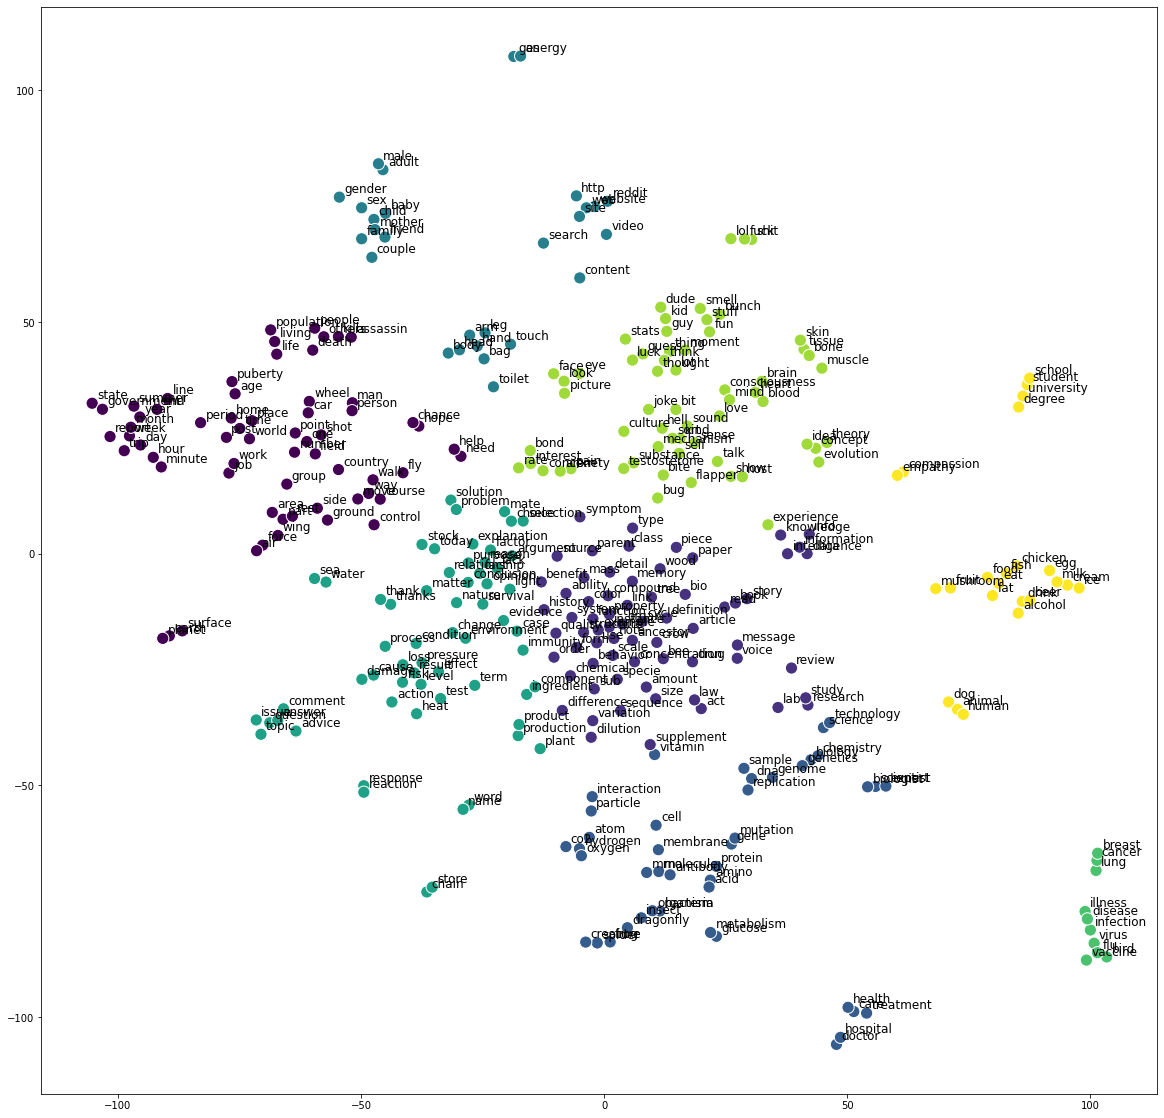

In [25]:
model1 = Word_Clusters(biology_df )

model1.stortextdata()

clusterdict, unique_list = model1.clusteranalysis('nouns', word_vectors, threshold=15, nrcluster = 8) 

In [26]:
clusterdict

{0: ['population',
  'time',
  'year',
  'living',
  'area',
  'post',
  'surface',
  'trip',
  'force',
  'control',
  'day',
  'course',
  'job',
  'people',
  'fly',
  'man',
  'need',
  'world',
  'work',
  'age',
  'part',
  'rest',
  'period',
  'end',
  'one',
  'minute',
  'place',
  'country',
  'way',
  'shot',
  'death',
  'number',
  'home',
  'person',
  'point',
  'earth',
  'ground',
  'summer',
  'week',
  'hour',
  'field',
  'group',
  'line',
  'air',
  'move',
  'month',
  'others',
  'hope',
  'chance',
  'life',
  'help',
  'walk',
  'assassin',
  'wing',
  'wheel',
  'car',
  'side',
  'kill',
  'planet',
  'state',
  'report',
  'government',
  'puberty'],
 1: ['instance',
  'cycle',
  'difference',
  'specie',
  'drug',
  'research',
  'wood',
  'class',
  'article',
  'data',
  'property',
  'act',
  'message',
  'sequence',
  'structure',
  'order',
  'amount',
  'use',
  'behavior',
  'concentration',
  'dilution',
  'example',
  'system',
  'study',
  'read

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


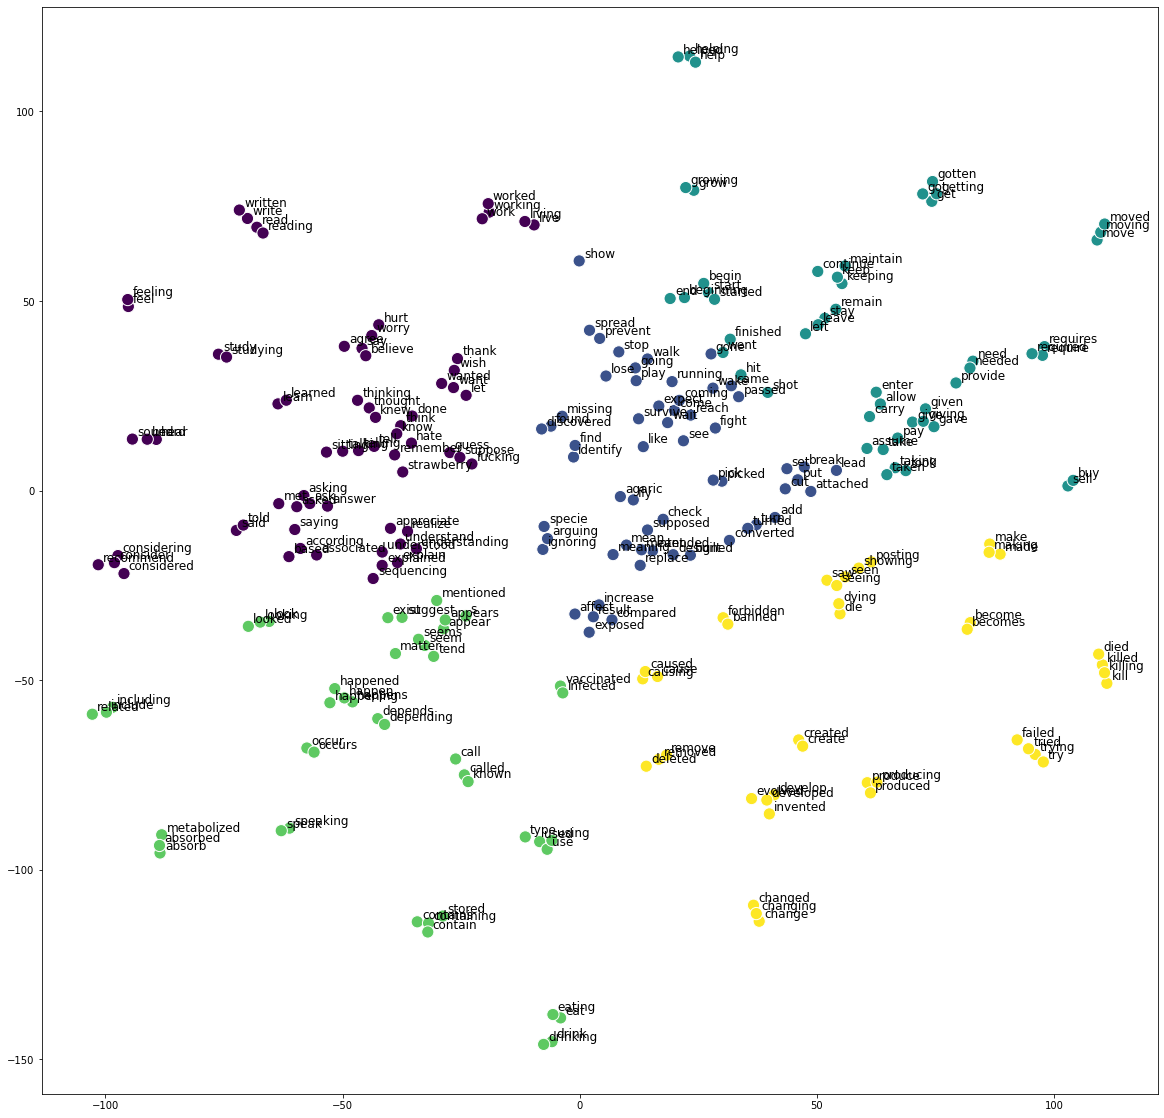

In [29]:
clusterdictverb, unique_list_verb = model1.clusteranalysis('verbs', word_vectors, threshold=10, nrcluster = 5) 

In [30]:
clusterdictverb

{0: ['live',
  'understanding',
  'say',
  'think',
  'feel',
  'want',
  'guess',
  'understood',
  'write',
  'know',
  'wanted',
  'let',
  'considered',
  'saying',
  'thought',
  'study',
  'asked',
  'said',
  'asking',
  'learn',
  'read',
  'hate',
  'reading',
  'hear',
  'appreciate',
  'considering',
  'sitting',
  'based',
  'thank',
  'believe',
  'explained',
  'tell',
  'sound',
  'working',
  'recommend',
  'suppose',
  'hurt',
  'realize',
  'talking',
  'heard',
  'work',
  'strawberry',
  'understand',
  'explain',
  'consider',
  'ask',
  'thinking',
  'living',
  'associated',
  'wish',
  'met',
  'done',
  'told',
  'worked',
  'worry',
  'fucking',
  'remember',
  'telling',
  'answer',
  'knew',
  'studying',
  'feeling',
  'agree',
  'according',
  'written',
  'learned',
  'sequencing'],
 1: ['going',
  'increase',
  'see',
  'fly',
  'intended',
  'picked',
  'built',
  'come',
  'mean',
  'found',
  'gone',
  'put',
  'missing',
  'ignoring',
  'walk',
  'sh

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


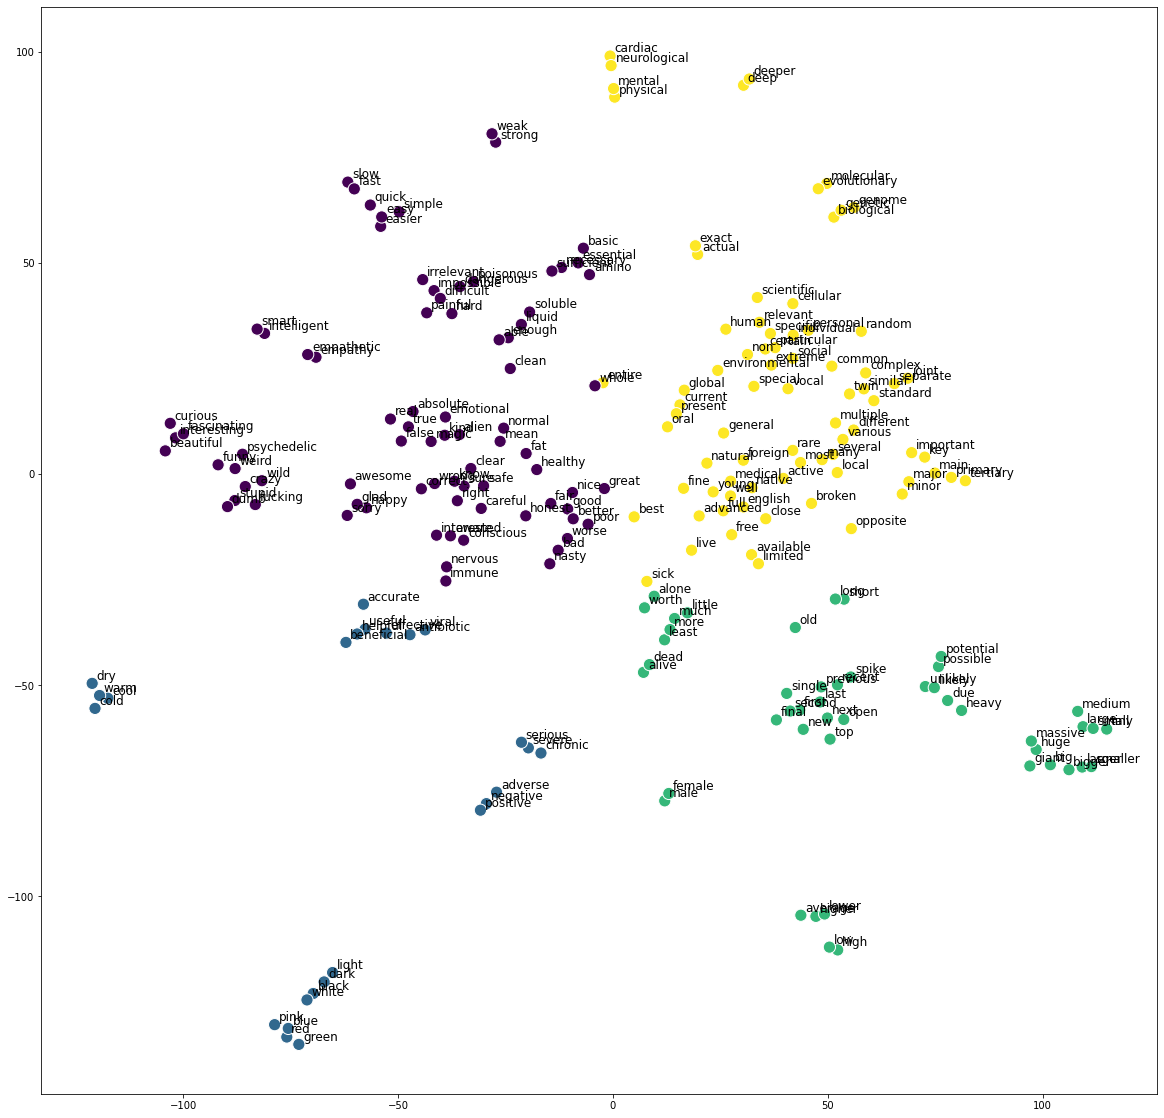

In [37]:
model1 = Word_Clusters(biology_df )

model1.stortextdata()
clusterdictadj, unique_list_verb = model1.clusteranalysis('adjectives', word_vectors, threshold=10, nrcluster = 4) 

In [41]:
clusterdictadj

{0: ['good',
  'enough',
  'better',
  'immune',
  'aware',
  'clean',
  'absolute',
  'kind',
  'healthy',
  'whole',
  'conscious',
  'sure',
  'interested',
  'impossible',
  'strong',
  'interesting',
  'able',
  'crazy',
  'bad',
  'easier',
  'sorry',
  'wrong',
  'hard',
  'awesome',
  'stupid',
  'basic',
  'real',
  'easy',
  'nasty',
  'empathy',
  'false',
  'magic',
  'wild',
  'correct',
  'poisonous',
  'intelligent',
  'nice',
  'right',
  'worse',
  'true',
  'beautiful',
  'dangerous',
  'normal',
  'clear',
  'fascinating',
  'dumb',
  'safe',
  'careful',
  'mean',
  'difficult',
  'amino',
  'soluble',
  'liquid',
  'irrelevant',
  'great',
  'fair',
  'know',
  'quick',
  'curious',
  'honest',
  'weak',
  'fucking',
  'smart',
  'empathetic',
  'slow',
  'fast',
  'weird',
  'happy',
  'glad',
  'funny',
  'painful',
  'poor',
  'essential',
  'alien',
  'simple',
  'psychedelic',
  'necessary',
  'emotional',
  'fat',
  'sufficient',
  'nervous'],
 1: ['negative'

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


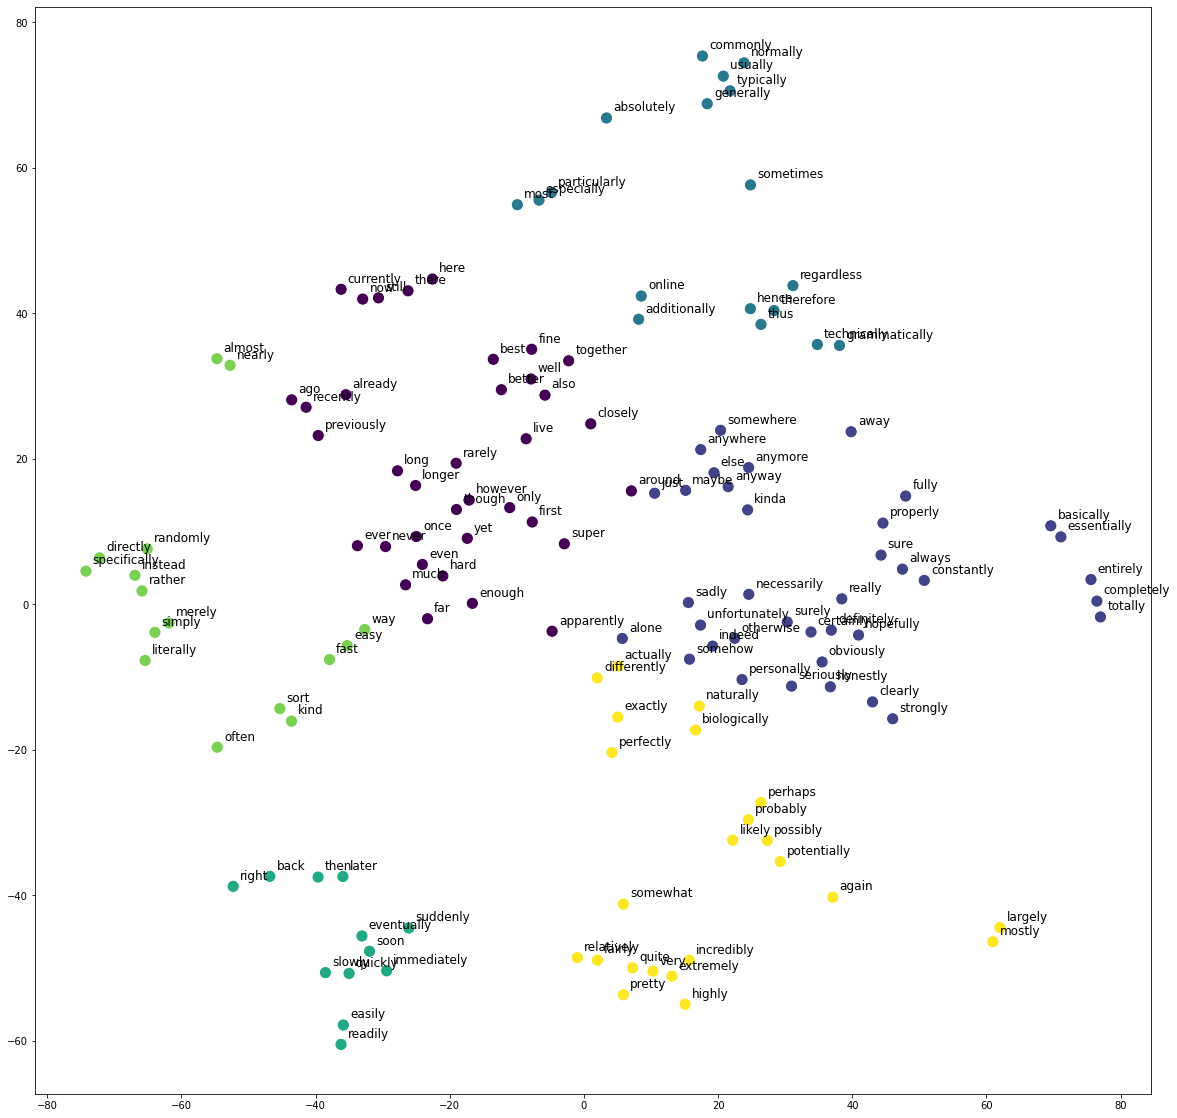

In [42]:
clusterdictadv, unique_list_verb = model1.clusteranalysis('adverbs', word_vectors, threshold=7, nrcluster = 6) 

In [43]:
clusterdictadv

{0: ['enough',
  'much',
  'however',
  'better',
  'already',
  'even',
  'far',
  'together',
  'well',
  'hard',
  'also',
  'never',
  'best',
  'previously',
  'still',
  'yet',
  'first',
  'there',
  'currently',
  'around',
  'live',
  'long',
  'ever',
  'apparently',
  'now',
  'here',
  'ago',
  'though',
  'longer',
  'super',
  'only',
  'closely',
  'fine',
  'recently',
  'once',
  'rarely'],
 1: ['definitely',
  'really',
  'kinda',
  'indeed',
  'fully',
  'hopefully',
  'basically',
  'always',
  'sure',
  'maybe',
  'unfortunately',
  'just',
  'anymore',
  'totally',
  'away',
  'completely',
  'else',
  'constantly',
  'personally',
  'entirely',
  'obviously',
  'otherwise',
  'clearly',
  'necessarily',
  'somewhere',
  'certainly',
  'alone',
  'honestly',
  'properly',
  'strongly',
  'sadly',
  'anyway',
  'seriously',
  'somehow',
  'anywhere',
  'essentially',
  'surely'],
 2: ['usually',
  'therefore',
  'regardless',
  'hence',
  'thus',
  'sometimes',
  '